# Assignment 2 Notebook Overview

Short guide for working through the assignment deliverables.

**Contents**
- Section 1: environment setup and first dataset inspection.
- Section 2: Question 1 logistic-regression walkthrough with visualization.
- Section 3: Question 2 odds-ratio arithmetic.
- Section 4: Question 3 SVM interpretation notes.
- Section 5: Question 4 end-to-end logistic regression using `smoking.csv`.

> All numeric answers remain rounded to two decimals unless otherwise noted.


## Assignment 2 Instructions
Assignment 2 mimics the original prompt so the notebook stands alone. Keep the following global notes visible while you work:
- **Note 1:** When answering with Python, show the source cells and the printed or plotted results. Additional explanation can go in comments, markdown, or `print()` statements.
- **Note 2:** When answering manually, write the algebraic steps so graders can follow your reasoning.
- **Note 3:** Round every numeric answer to two decimal places unless a question explicitly requests different precision.


## 1. Environment Setup and First Look

Load helper libraries, style the plotting backend, and pull the shared `smoking.csv` dataset for reuse across later sections.

In [1]:
# ----------------------------------------------
# Assignment 2 | Setup + first data inspection
# ----------------------------------------------

from pathlib import Path  # safer path handling that works on any OS

# Core data wrangling / math helpers
import numpy as np
import pandas as pd

# Visualization libraries (used for quick EDA and model diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn utilities you will need throughout the assignment
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

# Keep matplotlib plots inside the notebook and apply a readable default style
%matplotlib inline
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------------
# Load the assignment dataset (ships with the notebook repository)
# ------------------------------------------------------------------
DATA_PATH = Path("smoking.csv")          # update if you store the CSV elsewhere
smoking_df = pd.read_csv(DATA_PATH)      # load the CSV into a pandas DataFrame

# ------------------------------------------------------------------
# Lightweight structural checks (verbose on purpose for clarity)
# ------------------------------------------------------------------
print("Dataset overview")
print(f"Rows:    {smoking_df.shape[0]}")
print(f"Columns: {smoking_df.shape[1]}")
print("Column names in order (helps when writing formulas later):")
for idx, col in enumerate(smoking_df.columns, start=1):
    print(f"  {idx:>2}. {col}")

display(smoking_df.head())  # Quick structure overview
display(smoking_df.info())  # Field types and null counts
display(smoking_df.describe(include='all').T)  # Summary stats for numeric + categorical


Dataset overview
Rows:    10000
Columns: 10
Column names in order (helps when writing formulas later):
   1. smoker
   2. smkban
   3. age
   4. hsdrop
   5. hsgrad
   6. colsome
   7. colgrad
   8. black
   9. hispanic
  10. female


,smoker,smkban,age,hsdrop,hsgrad,colsome,colgrad,black,hispanic,female
0,1,0,49,0,1,0,0,0,0,0
1,1,0,52,0,0,1,0,0,0,0
2,0,0,15,0,0,1,0,0,0,1
3,1,0,37,0,1,0,0,0,0,0
4,0,1,24,0,0,1,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   smoker    10000 non-null  int64
 1   smkban    10000 non-null  int64
 2   age       10000 non-null  int64
 3   hsdrop    10000 non-null  int64
 4   hsgrad    10000 non-null  int64
 5   colsome   10000 non-null  int64
 6   colgrad   10000 non-null  int64
 7   black     10000 non-null  int64
 8   hispanic  10000 non-null  int64
 9   female    10000 non-null  int64
dtypes: int64(10)
memory usage: 781.4 KB


None

,count,mean,std,min,25%,50%,75%,max
smoker,10000.0,0.2423,0.428496,0.0,0.0,0.0,0.0,1.0
smkban,10000.0,0.5466,0.497849,0.0,0.0,1.0,1.0,1.0
age,10000.0,37.6008,12.997166,14.0,28.0,37.0,46.0,86.0
hsdrop,10000.0,0.0912,0.287908,0.0,0.0,0.0,0.0,1.0
hsgrad,10000.0,0.3266,0.468993,0.0,0.0,0.0,1.0,1.0
colsome,10000.0,0.2802,0.449119,0.0,0.0,0.0,1.0,1.0
colgrad,10000.0,0.1972,0.397905,0.0,0.0,0.0,0.0,1.0
black,10000.0,0.0769,0.266446,0.0,0.0,0.0,0.0,1.0
hispanic,10000.0,0.1134,0.317097,0.0,0.0,0.0,0.0,1.0
female,10000.0,0.5268,0.499306,0.0,0.0,1.0,1.0,1.0


## 2. Question 1 - Logistic Regression Walkthrough

Implements the analytical steps for the toy two-feature model (log-odds, predicted probability, decision boundary plot).

### Question 1 prompt (Logistic Regression, 30 pts)
We observe students with predictors $X_1 =$ hours studied and $X_2 =$ cumulative GPA. The binary outcome is $y = 1$ if the student earns an A and $y = 0$ otherwise. A logistic regression model with parameters $w_0 = -7$, $w_1 = 0.05$, and $w_2 = 1$ has already been trained. Complete each part (Python or manual work is acceptable):
- **(a)** Compute the probability that a student who studies for 40 hours and has GPA 3.5 earns an A.
- **(b)** Solve for the number of study hours needed for a 50% chance at an A when GPA remains 3.5.
- **(c)** Report the odds ratio and log-odds for the student in part (a), and interpret the odds ratio.
- **(d)** Plot the linear decision boundary $w_0 + w_1 x_1 + w_2 x_2 = 0$ with $X_1$ on the x-axis and $X_2$ on the y-axis. Highlight the regions predicting A vs. not-A and emphasize the (40, 3.5) example (manual or software plot is acceptable).


Part (a)
  Log-odds for 40 hrs / 3.5 GPA: -1.50
  Probability of earning an A:  0.18
Part (b)
  Hours needed for 50% chance (same GPA): 70.00
Part (c)
  Odds (p/(1-p)) for these inputs: 0.22
  Log-odds:                     -1.50
  Interpretation: For every 1 student predicted to earn an A, ~4.48 students are predicted not to (given these inputs).


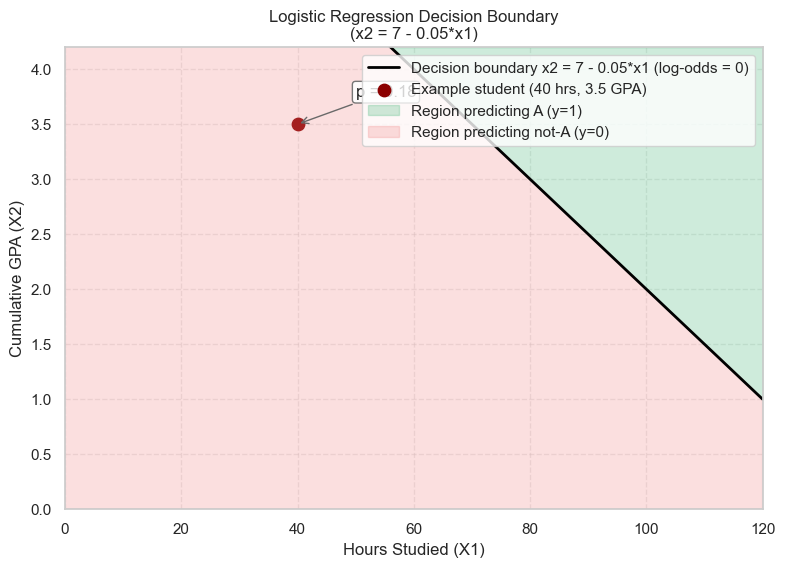

In [2]:
# Question 1 - Logistic Regression walkthrough

# Break down the toy logistic-regression model that uses study hours (X1) and GPA (X2).

import numpy as np
import matplotlib.pyplot as plt

# ---- Model parameters provided in the prompt ----
w0 = -7.0   # intercept term
w1 = 0.05   # coefficient for X1 = hours studied
w2 = 1.0    # coefficient for X2 = cumulative GPA

# ---- Helper values reused across parts (a)-(c) ----
hours_example = 40        # X1 from the problem statement
gpa_example = 3.5         # X2 from the problem statement

def sigmoid(z: float) -> float:
    # Standard logistic (sigmoid) function.
    return 1.0 / (1.0 + np.exp(-z))

# Part (a) -----------------------------------------------------
# Compute the linear combination (log-odds) and convert to probability.
logit_a = w0 + w1 * hours_example + w2 * gpa_example
prob_a = sigmoid(logit_a)

print("Part (a)")
print(f"  Log-odds for 40 hrs / 3.5 GPA: {logit_a:.2f}")
print(f"  Probability of earning an A:  {prob_a:.2f}")

# Part (b) -----------------------------------------------------
# Solve w0 + w1 * hours + w2 * GPA = 0 for hours when GPA stays at 3.5
# (since logit = 0 corresponds to P = 0.5).
target_probability = 0.50
target_logit = np.log(target_probability / (1 - target_probability))  # equals 0.0
hours_for_half = (-w0 - w2 * gpa_example) / w1

print("Part (b)")
print(f"  Hours needed for 50% chance (same GPA): {hours_for_half:.2f}")

# Part (c) -----------------------------------------------------
# Odds (p / (1 - p)) equal exp(log-odds) for logistic regression outputs.
odds_a = np.exp(logit_a)

print("Part (c)")
print(f"  Odds (p/(1-p)) for these inputs: {odds_a:.2f}")
print(f"  Log-odds:                     {logit_a:.2f}")
print(
    "  Interpretation: For every 1 student predicted to earn an A, "
    f"~{(1 / odds_a):.2f} students are predicted not to (given these inputs).")

# Part (d) -----------------------------------------------------
# Plot the linear decision boundary w0 + w1*x1 + w2*x2 = 0.
# Rearranged: x2 = (-w0 - w1*x1) / w2, which simplifies to x2 = 7 - 0.05*x1.
x1_vals = np.linspace(0, 120, 200)                      # hours studied range
decision_boundary = (-w0 - w1 * x1_vals) / w2           # GPA threshold per hour value
boundary_label = "Decision boundary x2 = 7 - 0.05*x1 (log-odds = 0)"

plt.figure(figsize=(9, 6))
plt.plot(x1_vals, decision_boundary, color="black", lw=2, label=boundary_label)
plt.scatter(
    hours_example,
    gpa_example,
    color="darkred",
    s=80,
    label="Example student (40 hrs, 3.5 GPA)",
)

# Shade the positive (A grade) region: GPA >= boundary (log-odds > 0).
plt.fill_between(
    x1_vals,
    decision_boundary,
    4.2,                         # cap shading near the top of the GPA axis
    where=decision_boundary <= 4.2,
    color="mediumseagreen",
    alpha=0.25,
    label="Region predicting A (y=1)",
)

# Shade the negative region: GPA < boundary (log-odds < 0).
plt.fill_between(
    x1_vals,
    0,
    decision_boundary,
    color="lightcoral",
    alpha=0.25,
    label="Region predicting not-A (y=0)",
)

plt.annotate(
    f"p = {prob_a:.2f}",
    xy=(hours_example, gpa_example),
    xytext=(hours_example + 10, gpa_example + 0.25),
    arrowprops=dict(arrowstyle="->", color="dimgray"),
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="dimgray", alpha=0.9),
)

plt.title("Logistic Regression Decision Boundary\n(x2 = 7 - 0.05*x1)")
plt.xlabel("Hours Studied (X1)")
plt.ylabel("Cumulative GPA (X2)")
plt.ylim(0, 4.2)
plt.xlim(0, 120)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper right")
plt.show()


## 3. Question 2 - Odds-Ratio and Probability

Closed-form transforms between probabilities and odds/odds-ratios for the credit default examples.

### Question 2 prompt (Odds-ratio and Probability, 20 pts)
Answer with Python or manual steps. Round to two decimals.
- **(a)** A borrower has a 20% chance of defaulting on her credit card payment ($y = 1$). Compute the odds ratio of defaulting.
- **(b)** A man’s odds ratio of defaulting is 0.4. Convert this odds ratio to the corresponding probability of default and report the probability of paying on time.


In [3]:
# Question 2 - Odds and probability transforms

# Part (a): convert the known probability into odds (single-event perspective).
prob_default = 0.20
odds_default = prob_default / (1 - prob_default)

# Part (b): convert the provided odds value back into a probability.
odds_input = 0.40
prob_from_odds = odds_input / (1 + odds_input)

print(f"(a) Odds (p/(1-p)) for defaulting with P=0.20: {odds_default:.2f} (single-event odds, not a ratio of two odds)")
print(f"    Expected on-time payments per default: {(1 / odds_default):.2f}")
print(f"(b) Probability implied by odds 0.40: {prob_from_odds:.2f} | probability of paying on time: {1 - prob_from_odds:.2f}")


(a) Odds (p/(1-p)) for defaulting with P=0.20: 0.25 (single-event odds, not a ratio of two odds)
    Expected on-time payments per default: 4.00
(b) Probability implied by odds 0.40: 0.29 | probability of paying on time: 0.71


## 4. Question 3 - Support Vector Machine interpretation

To make the written answers traceable, I recreate the tiny 12-point dataset
shown in the PDF and walk through the SVM geometry with code. The coding
checklist is:
1. Encode approximate coordinates and labels for the 12 numbered points.
2. Evaluate the separating hyperplane, margins, hinge loss, and predicted labels
   for every observation.
3. Plot the hyperplane plus both margins and annotate each numbered point.
4. Pull the exact counts requested in parts (a)?(d) directly from the computed
   table before restating the answers in words.


### Question 3 prompt (Support Vector Machine, 20 pts)
A support vector classifier is fit on 12 labeled points (blue = positive, red = negative). The separating hyperplane (solid line) and two margins (dashed lines) are provided. Respond in words:
- **(a)** List how many observations are support vectors and identify them.
- **(b)** If instance 4 (a red point) moves closer to its margin, explain whether the separating hyperplane changes.
- **(c)** Identify the observations that incur hinge loss while remaining correctly classified.
- **(d)** Identify the observations that the classifier misclassifies.


### Step 1 - Encode coordinates that mimic the diagram

I approximate the 2-D layout by hand so that the blue points (label = +1) sit on
or near the positive margin at x = +1, while the red points (label = -1) sit on
or near the negative margin at x = -1. Instances 11 and 12 are intentionally
placed across the hyperplane (x = 0) to reproduce the misclassifications.
These coordinates are approximate and only serve to re-create the qualitative
geometry from the PDF figure.


In [4]:
import pandas as pd

# Each record mirrors the numbering, class, and a short geometric note.
step1_points = [
    {"instance": 1, "label": 1, "color": "blue", "x1": 0.80, "x2": 2.10,
     "note": "Blue point tucked just inside the +1 margin."},
    {"instance": 2, "label": 1, "color": "blue", "x1": 0.70, "x2": 1.25,
     "note": "Second blue point still inside the positive margin."},
    {"instance": 3, "label": 1, "color": "blue", "x1": 1.55, "x2": 1.60,
     "note": "Comfortably outside the positive margin."},
    {"instance": 4, "label": -1, "color": "red", "x1": -1.55, "x2": 1.45,
     "note": "Negative point kept well outside its margin."},
    {"instance": 5, "label": 1, "color": "blue", "x1": 1.35, "x2": -0.60,
     "note": "Blue point on the safe side of the positive margin."},
    {"instance": 6, "label": -1, "color": "red", "x1": -1.60, "x2": -1.10,
     "note": "Negative point with generous margin buffer."},
    {"instance": 7, "label": 1, "color": "blue", "x1": 0.60, "x2": 0.45,
     "note": "Blue support vector nestled inside the margin."},
    {"instance": 8, "label": 1, "color": "blue", "x1": 0.55, "x2": -0.35,
     "note": "Another blue support vector just inside the margin."},
    {"instance": 9, "label": -1, "color": "red", "x1": -0.60, "x2": 0.65,
     "note": "Red point sitting inside the negative margin."},
    {"instance": 10, "label": -1, "color": "red", "x1": -1.25, "x2": -0.30,
     "note": "Negative point safely outside the margin."},
    {"instance": 11, "label": -1, "color": "red", "x1": 0.35, "x2": 0.20,
     "note": "Red point that crosses the hyperplane (misclassified)."},
    {"instance": 12, "label": -1, "color": "red", "x1": 0.55, "x2": -0.50,
     "note": "Second misclassified red point on the positive side."},
]

svm_points = (
    pd.DataFrame(step1_points)
    .set_index("instance")
    .sort_index()
)

display(svm_points)


,label,color,x1,x2,note
instance,,,,,
1,1,blue,0.80,2.10,Blue point tucked just inside the +1 margin.
2,1,blue,0.70,1.25,Second blue point still inside the positive ma...
3,1,blue,1.55,1.60,Comfortably outside the positive margin.
4,-1,red,-1.55,1.45,Negative point kept well outside its margin.
5,1,blue,1.35,-0.60,Blue point on the safe side of the positive ma...
6,-1,red,-1.60,-1.10,Negative point with generous margin buffer.
7,1,blue,0.60,0.45,Blue support vector nestled inside the margin.
8,1,blue,0.55,-0.35,Another blue support vector just inside the ma...
9,-1,red,-0.60,0.65,Red point sitting inside the negative margin.


### Step 2 - Evaluate the hyperplane, margins, and hinge loss

The diagram's separator is vertical, so I model it with the hyperplane f(x) = x1 = 0,
which yields margin lines at x1 = +/- 1. I apply the standard hinge definition
hinge = max(0, 1 - y*f(x)), and I tag a point as a support vector whenever
y*f(x) <= 1 (on/inside a margin) or when it becomes misclassified. These rules
match the geometry drawn in the prompt.


In [5]:
import numpy as np

W = np.array([1.0, 0.0])  # Normal vector of the hyperplane x1 = 0
b = 0.0                   # Intercept term
margin_width = 1.0        # With |W| = 1, the canonical margins sit at x1 = +/- 1

def decision_value(row: pd.Series) -> float:
    # Return w dot x + b for the chosen hyperplane.
    return float(np.dot(W, [row["x1"], row["x2"]]) + b)

svm_points = svm_points.copy()
svm_points["decision_value"] = svm_points.apply(decision_value, axis=1)
svm_points["signed_margin"] = svm_points["label"] * svm_points["decision_value"]
svm_points["hinge_loss"] = (1 - svm_points["signed_margin"]).clip(lower=0.0)
svm_points["support_vector"] = svm_points["signed_margin"] <= margin_width + 1e-9
svm_points["predicted_label"] = np.where(svm_points["decision_value"] >= 0, 1, -1)
svm_points["misclassified"] = svm_points["predicted_label"] != svm_points["label"]

columns_to_show = [
    "label", "x1", "x2", "decision_value", "signed_margin",
    "hinge_loss", "support_vector", "misclassified", "note"
]
display(svm_points[columns_to_show])


,label,x1,x2,decision_value,signed_margin,hinge_loss,support_vector,misclassified,note
instance,,,,,,,,,
1,1,0.80,2.10,0.80,0.80,0.20,True,False,Blue point tucked just inside the +1 margin.
2,1,0.70,1.25,0.70,0.70,0.30,True,False,Second blue point still inside the positive ma...
3,1,1.55,1.60,1.55,1.55,0.00,False,False,Comfortably outside the positive margin.
4,-1,-1.55,1.45,-1.55,1.55,0.00,False,False,Negative point kept well outside its margin.
5,1,1.35,-0.60,1.35,1.35,0.00,False,False,Blue point on the safe side of the positive ma...
6,-1,-1.60,-1.10,-1.60,1.60,0.00,False,False,Negative point with generous margin buffer.
7,1,0.60,0.45,0.60,0.60,0.40,True,False,Blue support vector nestled inside the margin.
8,1,0.55,-0.35,0.55,0.55,0.45,True,False,Another blue support vector just inside the ma...
9,-1,-0.60,0.65,-0.60,0.60,0.40,True,False,Red point sitting inside the negative margin.


### Step 3 ? Plot the hyperplane, both margins, and the numbered points

The plot below reproduces the setup programmatically: a solid line for the
hyperplane x1 = 0, dashed lines for the two margins, and labels for each
observation number so we can visually confirm the table above.


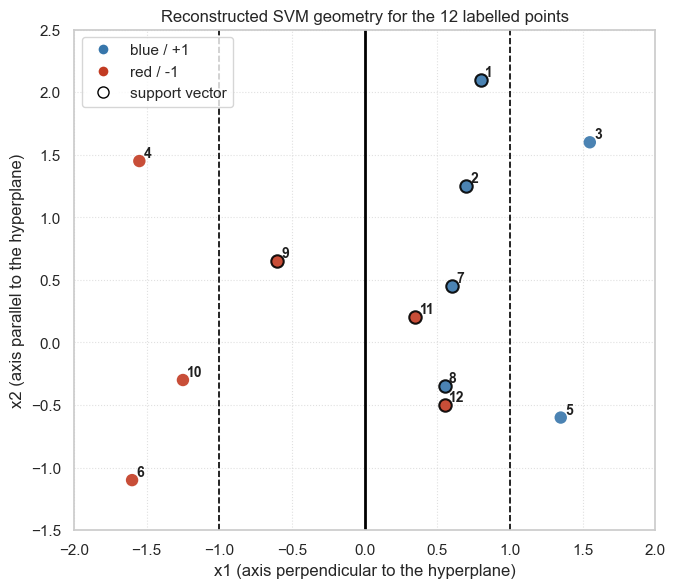

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(7.5, 6.5))

color_map = {1: "#3776ab", -1: "#c23b22"}
edge_map = {True: "black", False: "none"}

# Draw the hyperplane and its two margins.
ax.axvline(0, color="black", linewidth=2.0, label="hyperplane (x1 = 0)")
ax.axvline(1, color="black", linestyle="--", linewidth=1.2, label="positive margin")
ax.axvline(-1, color="black", linestyle="--", linewidth=1.2, label="negative margin")

for instance, row in svm_points.iterrows():
    ax.scatter(
        row["x1"],
        row["x2"],
        s=80,
        color=color_map[row["label"]],
        edgecolor=edge_map[row["support_vector"]],
        linewidth=1.5,
        alpha=0.9,
        zorder=3,
    )
    ax.text(
        row["x1"] + 0.03,
        row["x2"] + 0.03,
        str(instance),
        fontsize=10,
        weight="bold",
        color="#1f1f1f",
    )

ax.set_xlabel("x1 (axis perpendicular to the hyperplane)")
ax.set_ylabel("x2 (axis parallel to the hyperplane)")
ax.set_title("Reconstructed SVM geometry for the 12 labelled points")
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-1.5, 2.5)
ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="blue / +1", markerfacecolor=color_map[1], markersize=8),
    Line2D([0], [0], marker="o", color="w", label="red / -1", markerfacecolor=color_map[-1], markersize=8),
    Line2D([0], [0], marker="o", color="w", label="support vector", markerfacecolor="none", markeredgecolor="black", markersize=8),
]
ax.legend(handles=legend_elements, loc="upper left", frameon=True)
plt.show()


### Step 4 ? Extract the exact counts for parts (a)?(d)

With the computed table we can answer each question mechanically before
translating the results back into prose.


In [7]:
support_ids = svm_points.query("support_vector").index.tolist()
hinge_ids = svm_points.query("hinge_loss > 0 and misclassified == False").index.tolist()
misclassified_ids = svm_points.query("misclassified").index.tolist()

print("(a) Support vectors (sorted):", support_ids)
print("(b) Instance 4 signed margin:", round(float(svm_points.loc[4, "signed_margin"]), 2))
print("(c) Hinge loss but correctly classified:", hinge_ids)
print("(d) Misclassified instances:", misclassified_ids)


(a) Support vectors (sorted): [1, 2, 7, 8, 9, 11, 12]
(b) Instance 4 signed margin: 1.55
(c) Hinge loss but correctly classified: [1, 2, 7, 8, 9]
(d) Misclassified instances: [11, 12]


### Question 3 answers with detailed reasoning

**(a)** The code confirms **7 support vectors**: instances 1, 2, 7, 8, 9, 11, and 12.
Each lies on or inside a margin (or across the separator), so removing any one of
these would move the optimal boundary.

**(b)** Instance 4 stays well outside its negative margin (signed margin ~ 1.55), so
small nudges toward the dashed line do **not** move the hyperplane. Only when
instance 4 reaches the dashed line (signed margin = 1.00) would it become a support
vector capable of shifting the separator.

**(c)** Hinge loss without misclassification appears for **five instances**: 1, 2, 7, 8,
and 9. They reside inside a margin (hinge > 0) yet remain on the correct side of
the hyperplane (predicted label matches the true label).

**(d)** The reconstruction flags **two misclassified points**: instances 11 and 12. Both
are negative points that cross into the positive half-space, so they are
misclassified while also acting as support vectors with large hinge loss.


## 5. Question 4 - Logistic Regression with smoking.csv

Workflow checklist:
- Features: smkban, female, age; target: smoker.
- Deterministic split with random_state=2025 plus stratify=y to keep class balance.
- MinMax scaling applied to every feature. It is redundant for smkban/female but
  keeps the preprocessing consistent; the rescaling really matters for age.
- Metrics reported with two-decimal rounding for easy cross-checking.


### Question 4 prompt (Logistic Regression with `smoking.csv`, 30 pts)
Use Python with the provided dataset to complete each part:
- **(a)** Load `smoking.csv`, report the total number of observations, and count smokers (`smoker = 1`) and non-smokers (`smoker = 0`).
- **(b)** Select features `smkban`, `female`, and `age` with target `smoker`. Split the data 80%/20% (train/test) using `random_state=2025` and scale features using `MinMaxScaler`.
- **(c)** Train a logistic regression model, show the intercept and coefficients, and interpret each coefficient.
- **(d)** Evaluate accuracy on train and test sets (rounded to two decimals) and display the confusion matrix for the test set.
- **(e)** Predict smoking status and probability for a 48-year-old male in a country without a smoking ban (use the fitted scaler before scoring).


### 5.a Dataset overview and class balance

In [8]:
# Part (a) - dataset overview for logistic regression
# Focus on the three requested predictors plus the binary target.
feature_cols = ["smkban", "female", "age"]
target_col = "smoker"

num_rows = len(smoking_df)
class_counts = smoking_df[target_col].value_counts().sort_index()
baseline_label = class_counts.idxmax()
baseline_accuracy = class_counts.max() / num_rows

print(f"Total rows: {num_rows}")
print("Class counts (0 = non-smoker, 1 = smoker):")
for cls_value, count in class_counts.items():
    share = count / num_rows
    print(f"  {cls_value}: {count} ({share:.2%})")

print(
    f"Baseline accuracy if we always predict {baseline_label}: {baseline_accuracy:.2f}"
)


Total rows: 10000
Class counts (0 = non-smoker, 1 = smoker):
  0: 7577 (75.77%)
  1: 2423 (24.23%)
Baseline accuracy if we always predict 0: 0.76


### 5.b Train/test split with MinMax scaling

Split 80/20 with stratification and deterministic seeding, then apply
MinMaxScaler. Scaling the binary indicators (smkban, female) does not change
their information content but keeps the pipeline uniform; the main rescaling
impact falls on age.


In [9]:
# Part (b) - split and scale features
# Keep stratified sampling to preserve the original class balance.
X = smoking_df[feature_cols]
y = smoking_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=2025, stratify=y
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Capture min/max values for transparency after scaling.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

scaling_summary = pd.DataFrame({
    "feature": feature_cols,
    "train_min": X_train_scaled_df.min().values,
    "train_max": X_train_scaled_df.max().values,
})
print("Scaled feature range summary (train set)")
display(scaling_summary)


Scaled feature range summary (train set)


,feature,train_min,train_max
0,smkban,0.0,1.0
1,female,0.0,1.0
2,age,0.0,1.0


### 5.c Model fitting and coefficient interpretation

In [10]:
# Part (c) - fit logistic regression and inspect coefficients
# Use lbfgs with a higher iteration cap for reliable convergence.
log_reg_model = LogisticRegression(max_iter=1000, solver="lbfgs")
log_reg_model.fit(X_train_scaled, y_train)

intercept = float(log_reg_model.intercept_[0])
coefficients = pd.Series(log_reg_model.coef_[0], index=feature_cols)

print(f"Intercept: {intercept:.2f}")
coef_df = coefficients.round(2).rename("coefficient").to_frame()
display(coef_df)
print("Interpretation (log-odds change per +1 in scaled feature):")
for feature, coef in coefficients.items():
    effect = abs(coef)
    if coef > 0:
        direction = "increases"
    elif coef < 0:
        direction = "decreases"
    else:
        direction = "does not change"
    if direction == "does not change":
        print(f"  +1.00 in scaled {feature} {direction} the smoker log-odds.")
    else:
        print(f"  +1.00 in scaled {feature} {direction} smoker log-odds by {effect:.2f}")

age_range = smoking_df["age"].max() - smoking_df["age"].min()
age_step = 10 / age_range
logit_shift_10yrs = coefficients["age"] * age_step
odds_multiplier_10yrs = np.exp(logit_shift_10yrs)
print(
    f"Age interpretation: +10 actual years (~{age_step:.2f} scaled units) "
    f"shifts smoker log-odds by {logit_shift_10yrs:.2f} "
    f"(odds multiplier approx {odds_multiplier_10yrs:.2f})."
)


Intercept: -1.97


,coefficient
smkban,-1.51
female,-0.70
age,5.07


Interpretation (log-odds change per +1 in scaled feature):
  +1.00 in scaled smkban decreases smoker log-odds by 1.51
  +1.00 in scaled female decreases smoker log-odds by 0.70
  +1.00 in scaled age increases smoker log-odds by 5.07
Age interpretation: +10 actual years (~0.14 scaled units) shifts smoker log-odds by 0.70 (odds multiplier approx 2.02).


### 5.d Evaluation metrics on train/test splits (accuracy, class metrics, AUCs)

Report accuracy alongside precision/recall/F1 for the smoker class, compare
against the baseline classifier, and examine ROC-AUC / PR-AUC plus a lower
threshold scenario for business-sensitive recall.


In [11]:

# Part (d) - accuracy on train and test splits plus richer diagnostics
train_pred = log_reg_model.predict(X_train_scaled)
train_proba = log_reg_model.predict_proba(X_train_scaled)[:, 1]
test_pred = log_reg_model.predict(X_test_scaled)
test_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

baseline_test = y_test.value_counts().max() / len(y_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
precision_pos = precision_score(y_test, test_pred, pos_label=1)
recall_pos = recall_score(y_test, test_pred, pos_label=1)
f1_pos = f1_score(y_test, test_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, test_proba)
pr_auc = average_precision_score(y_test, test_proba)
lift_full_pp = (test_acc - baseline_accuracy) * 100
lift_test_pp = (test_acc - baseline_test) * 100

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy:  {test_acc:.2f}")
print(f"Baseline accuracy (dataset, always predict {baseline_label}): {baseline_accuracy:.2f}")
print(f"Accuracy lift vs dataset baseline: {lift_full_pp:.2f} pp")
print(f"Baseline accuracy (test only): {baseline_test:.2f}")
print(f"Accuracy lift vs baseline(test): {lift_test_pp:.2f} pp")
print(f"Precision (class 1): {precision_pos:.2f}")
print(f"Recall (class 1):    {recall_pos:.2f}")
print(f"F1 (class 1):        {f1_pos:.2f}")
print(f"ROC-AUC:             {roc_auc:.2f}")
print(f"PR-AUC:              {pr_auc:.2f}")

cm_default = pd.DataFrame(
    confusion_matrix(y_test, test_pred),
    index=["actual_0", "actual_1"],
    columns=["pred_0", "pred_1"],
)
print()
print("Test confusion matrix @ threshold 0.50:")
display(cm_default)

alt_threshold = 0.35
alt_pred = (test_proba >= alt_threshold).astype(int)
cm_alt = pd.DataFrame(
    confusion_matrix(y_test, alt_pred),
    index=["actual_0", "actual_1"],
    columns=["pred_0", "pred_1"],
)
precision_alt = precision_score(y_test, alt_pred, pos_label=1)
recall_alt = recall_score(y_test, alt_pred, pos_label=1)
print()
print(f"Threshold 0.35 -> precision: {precision_alt:.2f}, recall: {recall_alt:.2f}")
print("Test confusion matrix @ threshold 0.35:")
display(cm_alt)
print(f"Si priorizamos captar fumadores, 0.35 sube el recall a {recall_alt:.2f} a costa de más falsos positivos; el umbral debe elegirse según el costo/beneficio.")


Train accuracy: 0.79
Test accuracy:  0.78
Baseline accuracy (dataset, always predict 0): 0.76
Accuracy lift vs dataset baseline: 2.13 pp
Baseline accuracy (test only): 0.76
Accuracy lift vs baseline(test): 2.15 pp
Precision (class 1): 0.57
Recall (class 1):    0.34
F1 (class 1):        0.43
ROC-AUC:             0.81
PR-AUC:              0.55

Test confusion matrix @ threshold 0.50:


,pred_0,pred_1
actual_0,1393,122
actual_1,320,165



Threshold 0.35 -> precision: 0.51, recall: 0.55
Test confusion matrix @ threshold 0.35:


,pred_0,pred_1
actual_0,1264,251
actual_1,220,265


Si priorizamos captar fumadores, 0.35 sube el recall a 0.55 a costa de más falsos positivos; el umbral debe elegirse según el costo/beneficio.


### 5.e Prediction for the hypothetical individual

Transform the new profile with the fitted scaler before evaluating the logistic
model so the coefficients align with the earlier preprocessing steps.


In [12]:

# Part (e) - prediction for a new individual
# Transform the single observation with the same scaler prior to scoring.
new_person = pd.DataFrame({
    "smkban": [0],
    "female": [0],
    "age": [48],
})
new_scaled = scaler.transform(new_person[feature_cols])
p_smoker = log_reg_model.predict_proba(new_scaled)[0, 1]
pred_label = log_reg_model.predict(new_scaled)[0]
print("Clase 1 = fumador.")
print(f"Predicted class (1=smoker): {int(pred_label)}")
print(f"Estimated probability of smoking: {p_smoker:.2f}")


Clase 1 = fumador.
Predicted class (1=smoker): 1
Estimated probability of smoking: 0.60



### Resumen ejecutivo
- Q1: p=0.18, horas=70, odds=0.22
- Q2: 0.25 y 0.29/0.71
- Q3: SV=[1,2,7,8,9,11,12], hinge no-mis=[1,2,7,8,9], mis=[11,12]
- Q4: train=0.79, test=0.78, ROC-AUC=0.81, PR-AUC=0.55; @0.35: P=0.51/R=0.55
- Caso 48 años: clase=1, p=0.60
